In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plot_x_size = 15
plot_y_size = 2



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
np.set_printoptions(precision = 6, suppress = True)

# date_list = [d.strftime('%Y-%m-%d') for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]

df = pd.read_csv('/content/drive/MyDrive/VDT2022/mini-project/stroke_recovery_dataset/protocol/sb01.csv')

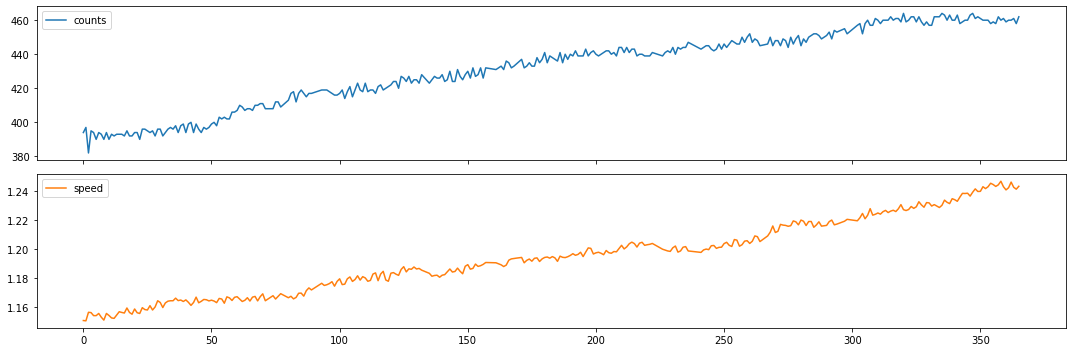

In [21]:
cols = ['counts', 'speed']
data_df = df.loc[df.index, cols]
data_df = data_df.interpolate()
fig,ax = plt.subplots(2, figsize=(15,5), sharex=True)
data_df.plot(ax=ax, subplots=True)
plt.xlabel('')
plt.tight_layout()
plt.show()

In [22]:
series = data_df.counts
print(series.name)

counts


## One-step Prediction

In [23]:
### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [25]:
### HYPERPARAMETERS ###
window_size = 3
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 92
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(271, 3)
(271,)
(92, 3)
(92,)


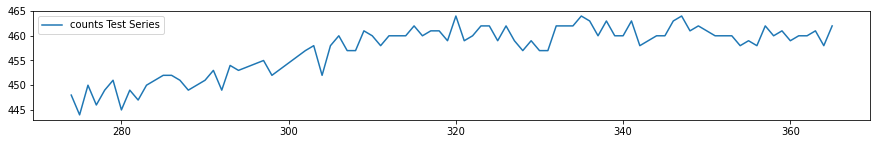

In [26]:
plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

series[-test_size:].plot(label = 'counts Test Series')
plt.legend()
plt.show()

In [27]:
import lightgbm as lgb

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

  3 --- MAE: -2.726 (0.266)
  5 --- MAE: -2.748 (0.433)
  7 --- MAE: -2.733 (0.314)
  9 --- MAE: -2.741 (0.361)
 14 --- MAE: -2.807 (0.443)


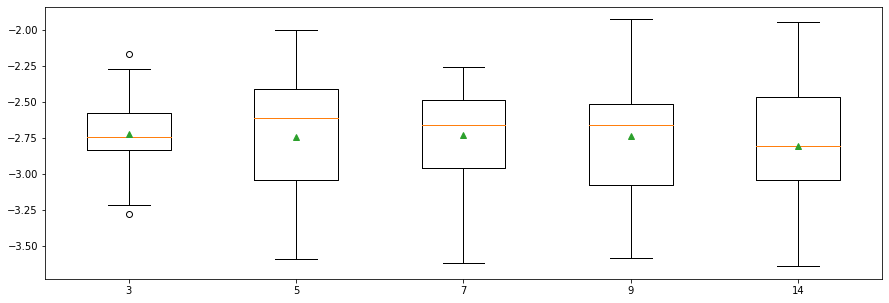

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

windows = [3,5,7,9,14]

results = []
names = []
for w in windows:

    window_size = w

    train_x, train_y = create_xy(train_series, window_size, prediction_horizon)

    train_y = train_y.flatten()

    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 123)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(w)
    print('%3d --- MAE: %.3f (%.3f)' % (w, np.mean(scores), np.std(scores)))

plt.rcParams['figure.figsize'] = [plot_x_size, 5]    
    
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

## Multi-step Prediction

In [51]:
### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 1

### TRAIN VAL SPLIT ###
test_size = 92
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(244, 30)
(244,)
(92, 30)
(92,)


### Recursive Forecasting

In [52]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          # early_stopping_rounds = 10, 
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

  One-Step MAE: 11.652624
Multi-Step MAE: 11.973473


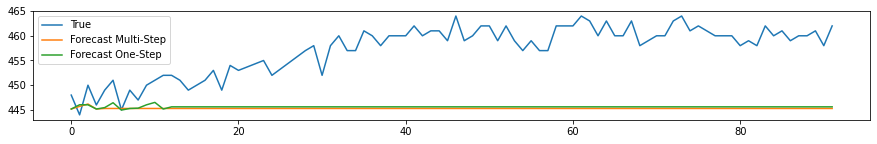

In [53]:
recursive_x = test_x[0, :]

forecast_ms = []
for i in range(test_x.shape[0]):
    pred = model.predict(recursive_x.reshape((1, recursive_x.shape[0])))
    recursive_x = np.append(recursive_x[1:], pred)
    forecast_ms.append(pred)
    
forecast_ms_rec = np.asarray(forecast_ms).flatten()
forecast_os = model.predict(test_x)

print('  One-Step MAE: %.6f' % (np.mean(np.abs(forecast_os - test_y))))
print('Multi-Step MAE: %.6f' % (np.mean(np.abs(forecast_ms_rec - test_y))))

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

plt.plot(test_y, label = 'True')
plt.plot(forecast_ms_rec, label = 'Forecast Multi-Step')
plt.plot(forecast_os, label = 'Forecast One-Step')
plt.legend()
plt.show()

### Direct Forecasting

In [57]:
### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 1

### TRAIN VAL SPLIT ###
test_size = 92
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

In [58]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)

model.fit(train_x, train_y)

MultiOutputRegressor(estimator=LGBMRegressor(), n_jobs=-1)

In [60]:
forecast_ms_dir = model.predict(test_x)

print('  One-Step MAE: %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Multi-Step MAE: %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y))))

# plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

# plt.plot(test_y, label = 'True')
# plt.plot(forecast_ms_dir.T, label = 'Forecast Multi-Step')
# plt.plot(forecast_os, label = 'Forecast One-Step')
# plt.legend()
# plt.show()

  One-Step MAE: 11.6574
Multi-Step MAE: 9.3231


  Recursive MAE: 11.9648
     Direct MAE: 9.3231
Combination MAE: 10.6344


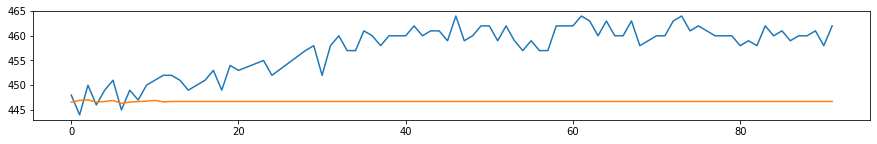

In [62]:
forecast_ms_comb = 0.5*forecast_ms_dir.flatten() + 0.5*forecast_ms_rec

print('  Recursive MAE: %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y))))
print('     Direct MAE: %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y))))
print('Combination MAE: %.4f' % (np.mean(np.abs(forecast_ms_comb - test_y))))

plt.plot(test_y, label = 'True')
plt.plot(forecast_ms_comb, label = 'Forecast Combination')
plt.show()

## LightGBM with Trend

In [67]:
%%capture
import os
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

!pip install statsmodels==0.12.2
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

!pip install sktime==0.6.1
!pip install pmdarima==1.8.2
import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

sns.set()
plt.style.use('bmh')

In [76]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


def plot_forecast(series_train, series_test, forecast, forecast_int=None):
    rmse = mean_squared_error(series_test, forecast)**0.5
    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"RMSE: {rmse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.6f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

In [82]:
def create_forecaster_w_detrender(degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=5, strategy="recursive"),
            ),
        ]
    )

    return forecaster

def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape

In [78]:
test_size = 92
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

In [81]:
def create_forecaster_w_detrender(degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=5, strategy="recursive"),
            ),
        ]
    )

    return forecaster


param_grid = {"forecast__window_length": [5, 10, 15, 20, 25, 30]}
forecaster = create_forecaster_w_detrender(degree=1)
lgb_rmse, lgb_mae, lgb_mape = grid_serch_forecaster(
    train_y, test_y, forecaster, param_grid
)

ValueError: ignored